In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import datetime
from IPython.display import HTML
from PIL import Image
from IPython.display import display, clear_output
from functions import SMA, Trend
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import re

import warnings
warnings.filterwarnings('ignore')

In [3]:
stochastic_df = pd.DataFrame(np.random.randint(0,100,size=(800, 1)), columns=list('R'))
stochastic_df['index'] = [i for i in range(len(stochastic_df))]

In [4]:
stochastic_df['delta'] = stochastic_df['R'] - stochastic_df['R'].shift(1)
start_step = stochastic_df['delta'].abs().min()
end_step = stochastic_df['delta'].max()

In [5]:
print(start_step)
print(end_step)

0.0
95.0


In [6]:
stochastic_df

,R,index,delta
0,81,0,NaN
1,48,1,-33.0
2,21,2,-27.0
3,79,3,58.0
4,66,4,-13.0
...,...,...,...
795,34,795,-9.0
796,69,796,35.0
797,67,797,-2.0
798,47,798,-20.0


## Зависимость отношения длины и ширины изображения к фрактальной размрености

In [7]:
optimal_demension_df = pd.read_excel('optimal_demension.xlsx')
optimal_demension_df['Длина/Высота'] = optimal_demension_df['Длина']/optimal_demension_df['Высота']

In [8]:
optimal_demension_df.loc[optimal_demension_df['Размерность']==1.5]

,Длина,Высота,dpi,Размерность,std,Длина/Высота
144,180,10,100,1.5,1.29,18.000000
163,190,15,100,1.5,1.29,12.666667
182,200,20,100,1.5,1.29,10.000000
201,210,25,100,1.5,1.29,8.400000
202,210,30,100,1.5,1.30,7.000000
221,220,35,100,1.5,1.29,6.285714
222,220,40,100,1.5,1.29,5.500000
223,220,45,100,1.5,1.30,4.888889
224,220,50,100,1.5,1.30,4.400000
225,220,55,100,1.5,1.30,4.000000


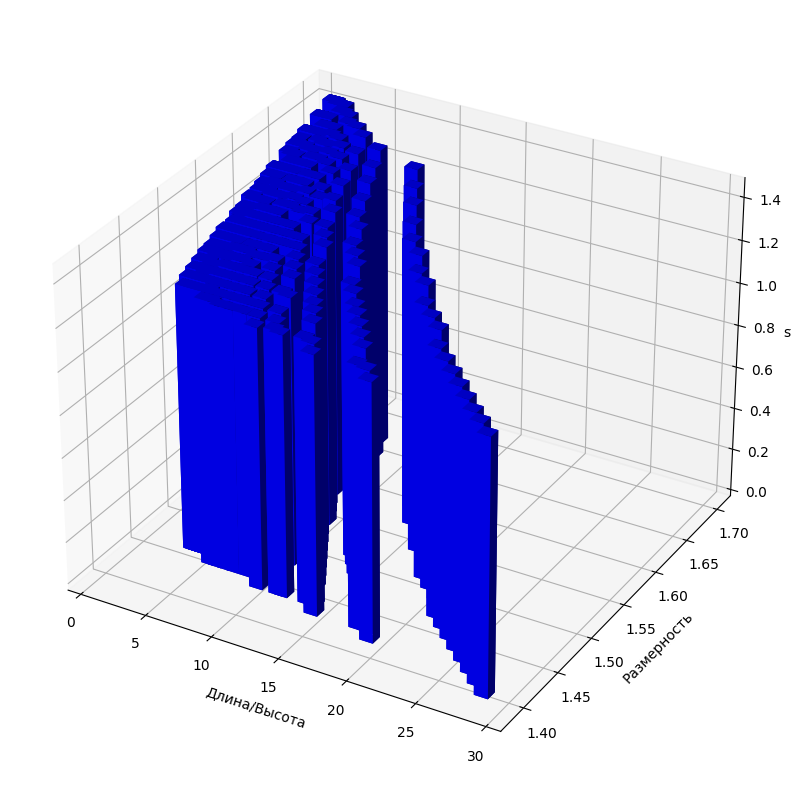

In [9]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Длина/Высота')
ax.set_ylabel('Размерность')
ax.set_zlabel('std')

x_pos = optimal_demension_df['Длина/Высота']
y_pos = optimal_demension_df['Размерность']
z_pos = [0] * len(optimal_demension_df)

x_size = 1
y_size = 0.01
z_size = optimal_demension_df['std']

# ax.scatter(xs, ys, zs, marker=m)
ax.bar3d(x_pos, y_pos, z_pos, x_size, y_size, z_size, color='blue', zsort='average')

## Зависимость фрактальной размерности от длины ряда и изображения

In [10]:
optimal_demension_df = pd.read_excel('optimal_demension_3.xlsx')

In [11]:
optimal_demension_df.loc[(optimal_demension_df['Размерность'] == 1.49) |\
                         (optimal_demension_df['Размерность'] == 1.50) |\
                         (optimal_demension_df['Размерность'] == 1.51)]

,Длина,Ширина,dpi,Размерность,std,Длина_ряда
4,100,50,100,1.50,1.30,400
12,200,50,100,1.49,1.29,800
19,300,50,100,1.50,1.29,1150
20,300,50,100,1.51,1.30,1200
21,300,50,100,1.51,1.31,1250
27,400,50,100,1.49,1.28,1550
28,400,50,100,1.50,1.29,1600
29,400,50,100,1.51,1.30,1650
33,500,50,100,1.49,1.28,1850
34,500,50,100,1.49,1.29,1900


## Функции нахождения размерности

In [12]:
def Dimension_Hurst(df, iter=10, show=True, Dimension=False):
    result = pd.DataFrame(columns=['Масштаб', 'Коэффициент'])
    for t in range(iter, 0, -1):
        chunks = np.array_split(df, t)
        R = np.array([(max(chunk) - min(chunk)) for chunk in chunks]).mean()
        S = np.array([np.std(chunk) for chunk in chunks]).mean()
        H = R / S * np.sqrt(len(chunks[0]))
        len_t = len(chunks[0])
        result.loc[len(result)] = [math.log(len_t), math.log(H)]

    z = np.polyfit(result['Масштаб'], result['Коэффициент'], 1)
    p = np.poly1d(z)

    D = round(2 - p[1], 2)
    std = round(np.std(result['Коэффициент']), 2)

    if show:
        plt.figure(figsize=(15, 5))
        plt.scatter(result['Масштаб'], result['Коэффициент'], color='red')
        plt.plot(result['Масштаб'], p(result['Масштаб']))

        plt.ylabel("ln(R/S)")
        plt.xlabel("ln(Длина отрезка)")

        plt.title(f'Размерность = {D}, стандартное отклонение {std}')
        plt.show()
        plt.clf()
        plt.close()
    else:
        plt.clf()
        plt.close()

    if Dimension:
        return D
    return result

In [13]:
def Dimension_BC(df, columns, start_step, end_step, step, show=True, Dimension=False):
    results = []
    steps = [i for i in range(start_step, end_step, step)]

    p1 = columns[0]
    p2 = columns[1]

    plt.figure(figsize=(200, 50), dpi=100)
    plt.plot(df[p1], df[p2], color='black')
    plt.axis('off')
    plt.savefig('BC.jpg', bbox_inches='tight', pad_inches=0)
    plt.clf()
    plt.close()

    img = (~np.asarray(Image.open('BC.jpg').convert('1'))).astype(int)
    # Вывод размера изображения
    print(img.shape)

    for step in steps:
        count = 0
        for i in range(1, img.shape[0], step):
            for j in range(1, img.shape[1], step):
                # Получаем срез массива
                window = img[i:i + step, j:j + step]
                # Прибавляем если сумма окна больше нуля
                if window.sum() > 0:
                    count += 1
        results.append(count)

    x = [math.log(step) for step in steps]
    y = [math.log(result) for result in results]

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)

    D = round(p[1] * (-1), 2)
    std = round(np.std(y), 2)

    if show:
        plt.figure(figsize=(15, 5))
        plt.scatter(x, y, color='red')
        plt.plot(x, p(x))

        plt.ylabel("ln(Кол-во занятых квадратов)")
        plt.xlabel("ln(Масштаб)")

        plt.title(f'Размерность = {D}, стандартное отклонение {std}')
        plt.show()
        plt.clf()
        plt.close()
    else:
        plt.clf()
        plt.close()

    if Dimension:
        return D
    return [x, y]

## Зависимость отклонения от количества шагов

Начальный шаг 5
Конечный шаг 200
Шаг 1
(3850, 15500)


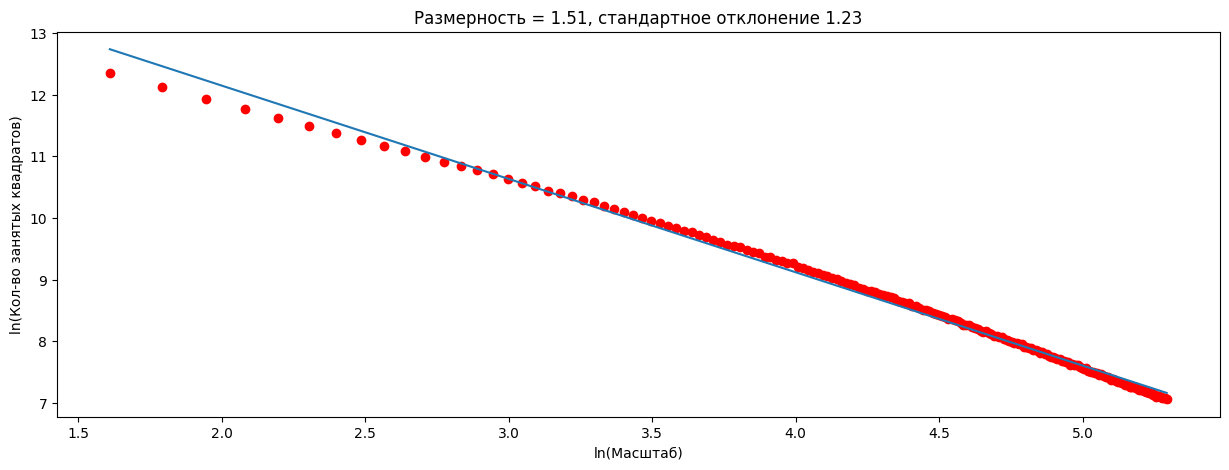

Начальный шаг 5
Конечный шаг 200
Шаг 5
(3850, 15500)


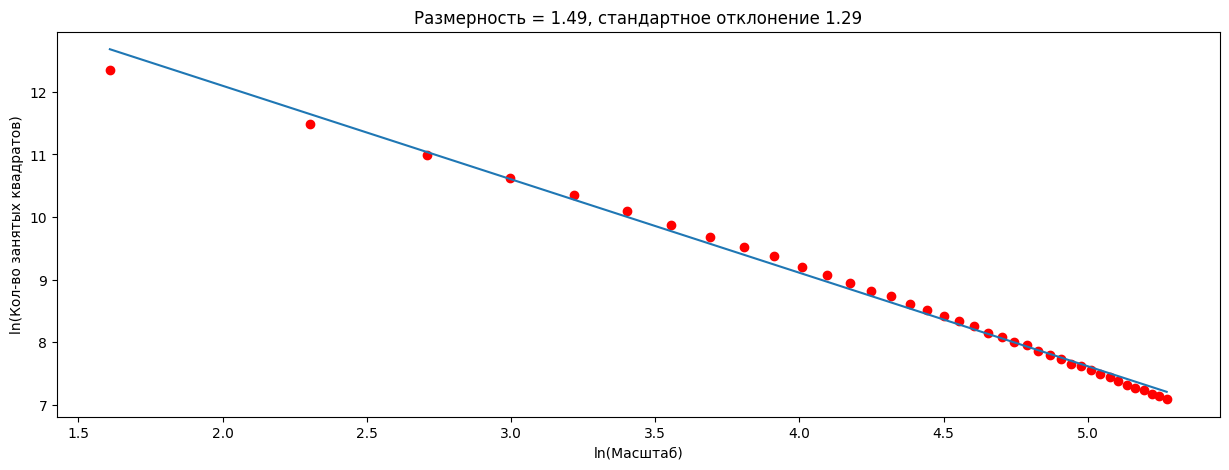

Начальный шаг 5
Конечный шаг 200
Шаг 10
(3850, 15500)


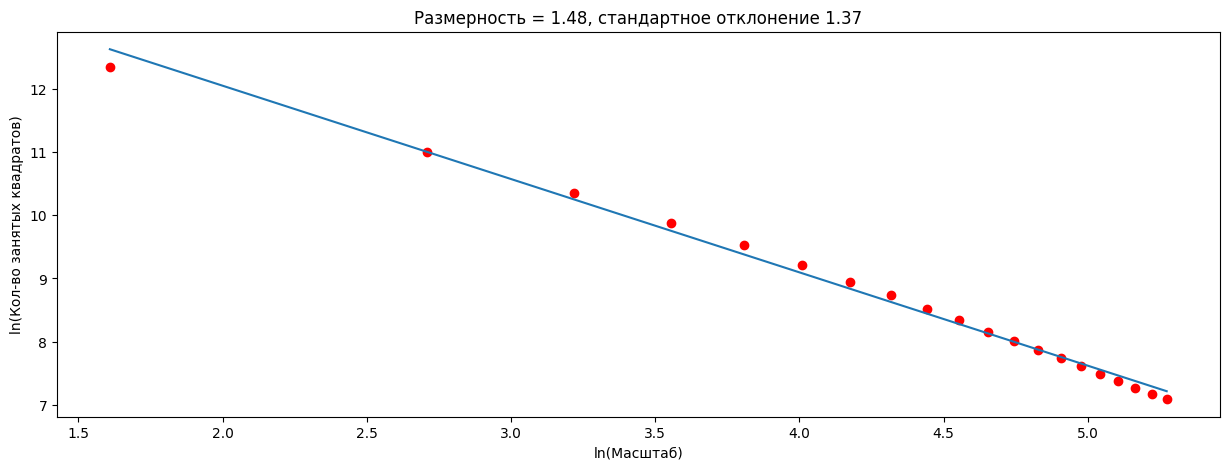

Начальный шаг 5
Конечный шаг 200
Шаг 15
(3850, 15500)


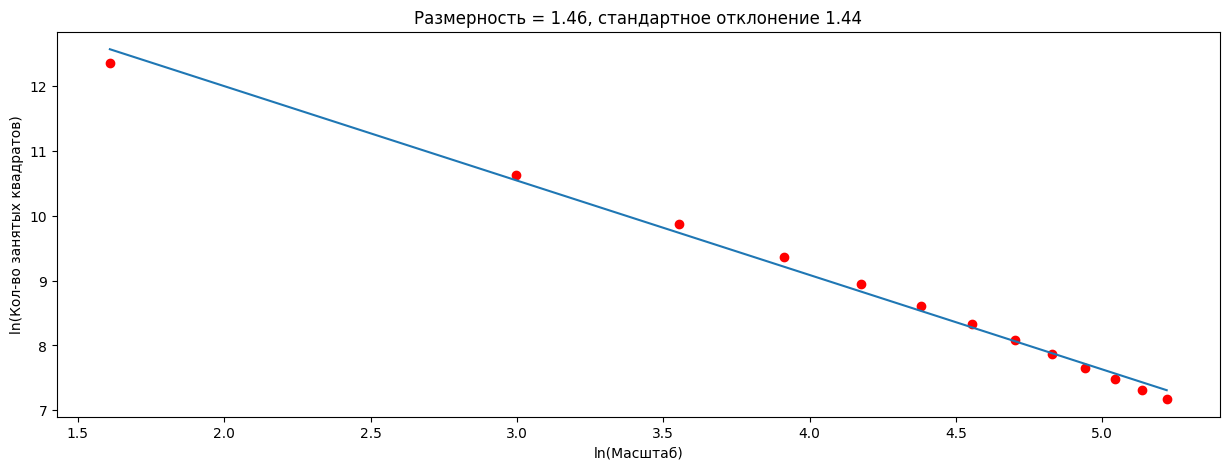

Начальный шаг 5
Конечный шаг 200
Шаг 20
(3850, 15500)


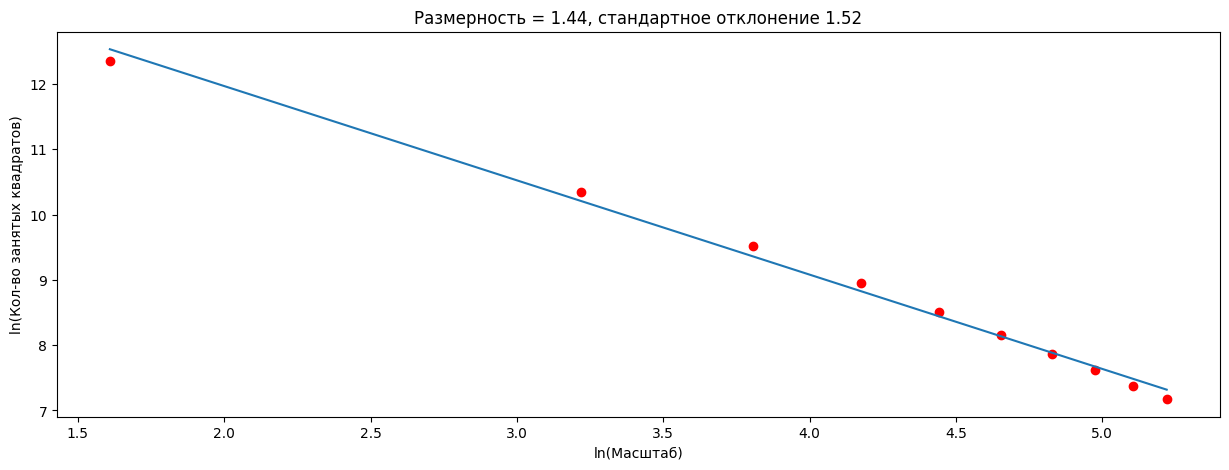

Начальный шаг 5
Конечный шаг 200
Шаг 25
(3850, 15500)


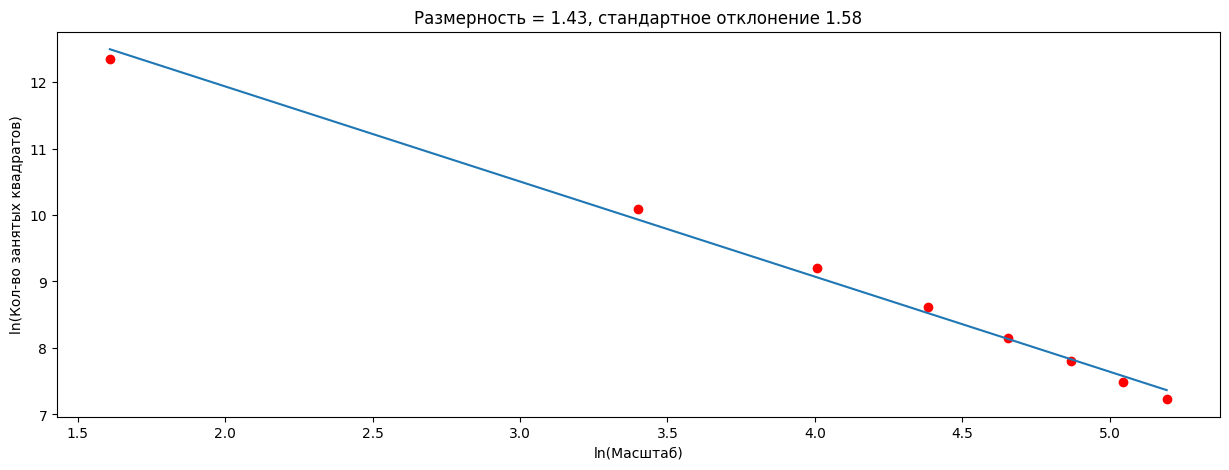

Начальный шаг 5
Конечный шаг 200
Шаг 30
(3850, 15500)


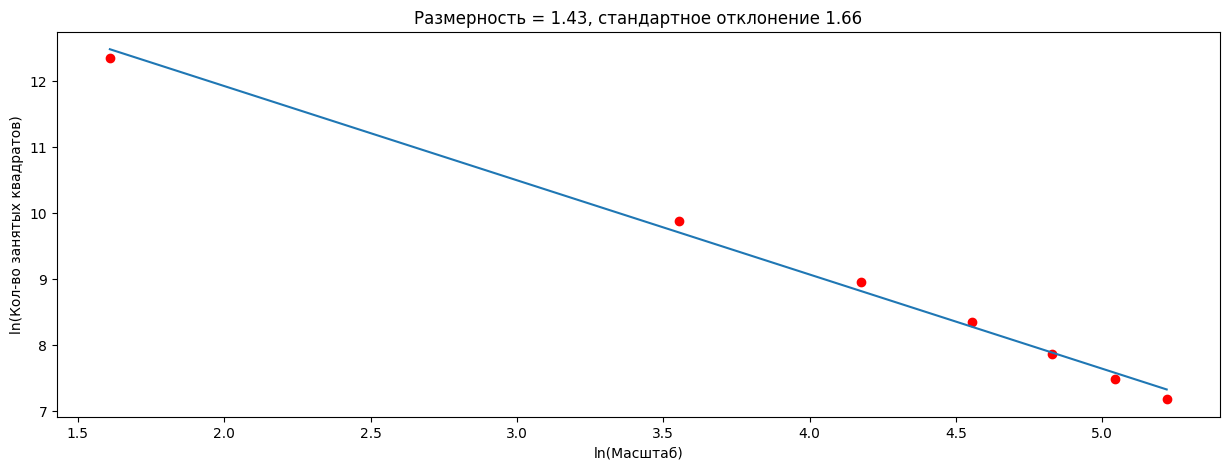

Начальный шаг 5
Конечный шаг 200
Шаг 35
(3850, 15500)


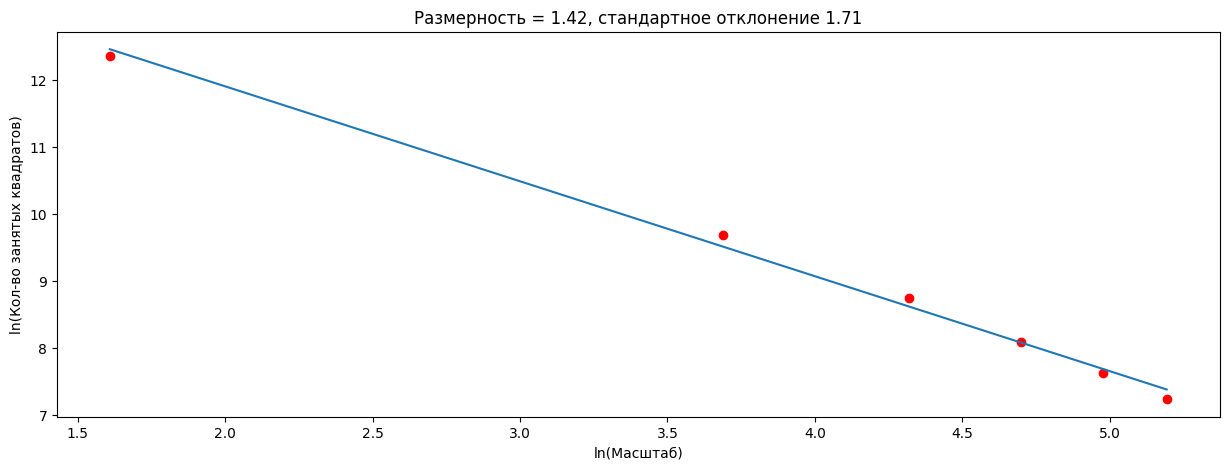

Начальный шаг 5
Конечный шаг 200
Шаг 40
(3850, 15500)


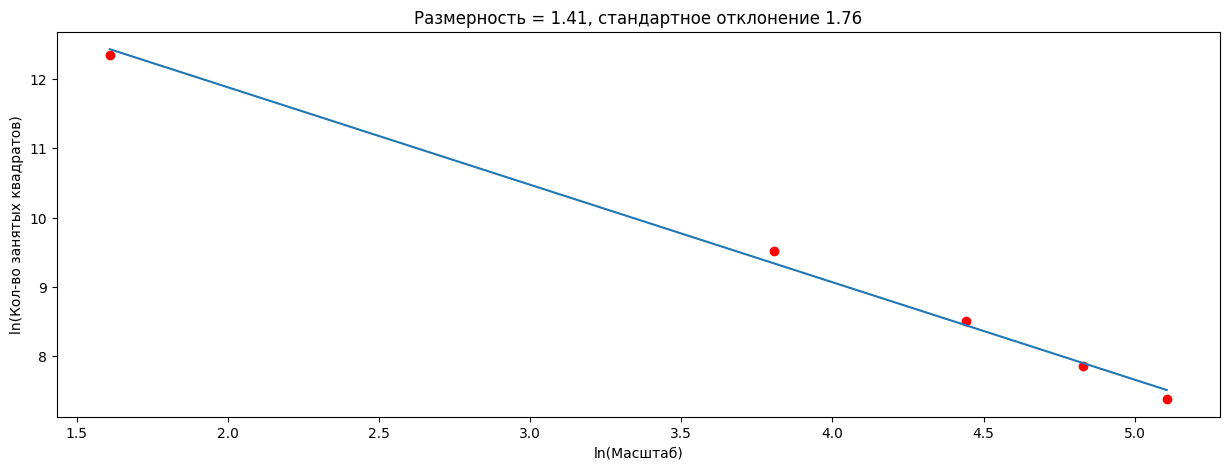

In [14]:
for start_step, end_step, step in zip([5]*9, [200]*9, [1, 5, 10, 15, 20, 25, 30, 35, 40]):
    print(f'Начальный шаг {start_step}')
    print(f'Конечный шаг {end_step}')
    print(f'Шаг {step}')
    D = Dimension_BC(stochastic_df, ['index', 'R'], start_step, end_step, step, show=True, Dimension=False)

## Зависимость отклонения от начального шага

Начальный шаг 5
Конечный шаг 200
Шаг 1
(3850, 15500)


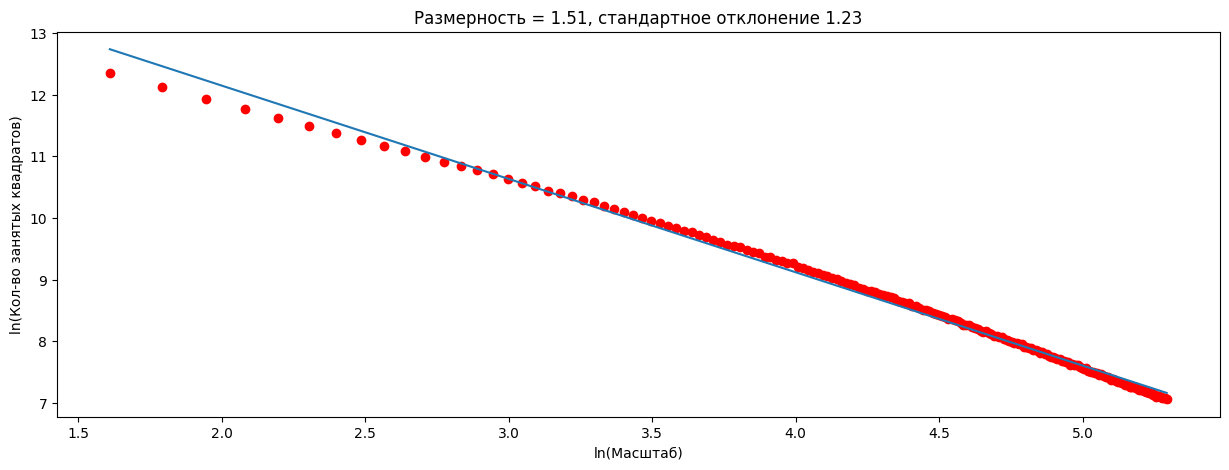

Начальный шаг 10
Конечный шаг 200
Шаг 1
(3850, 15500)


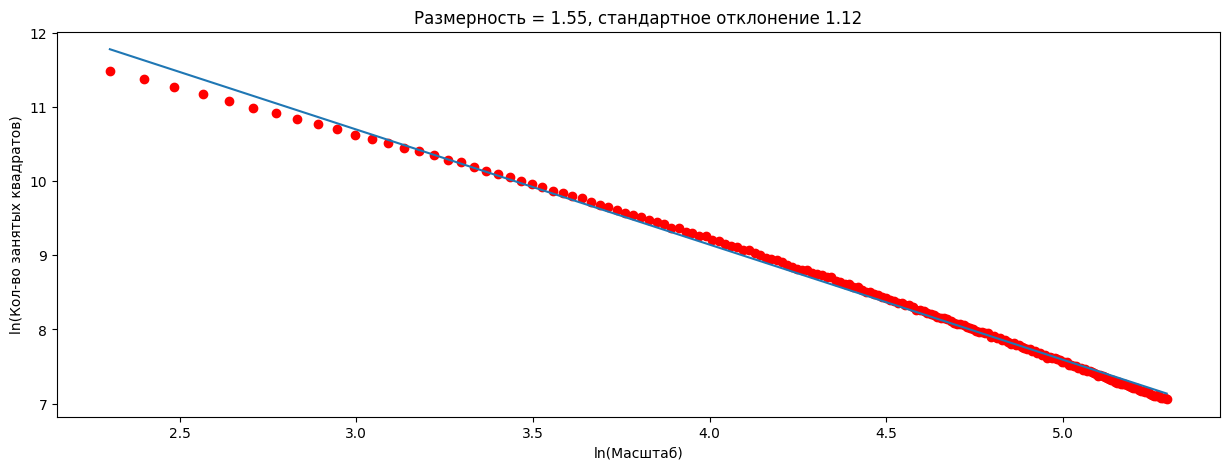

Начальный шаг 20
Конечный шаг 200
Шаг 1
(3850, 15500)


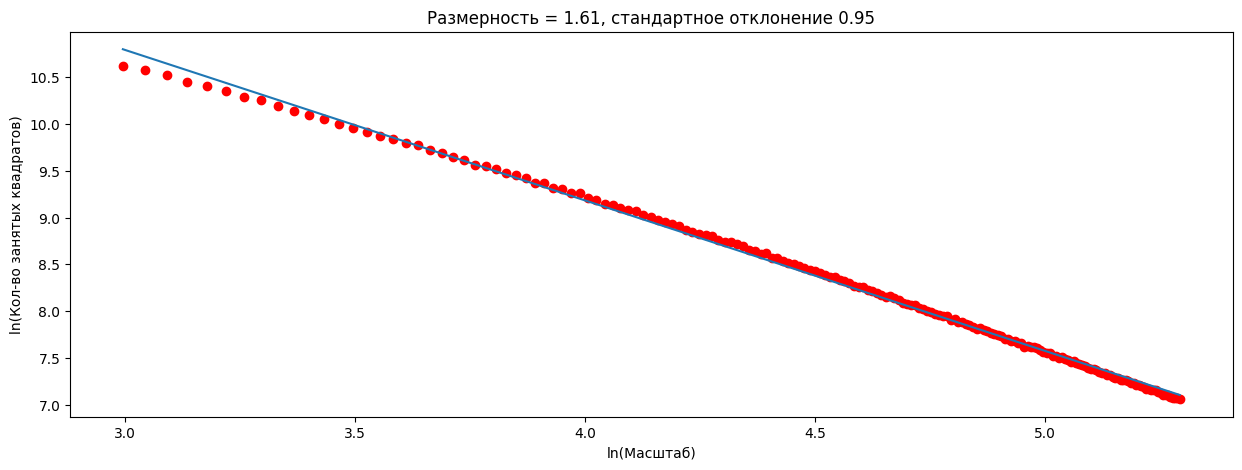

Начальный шаг 30
Конечный шаг 200
Шаг 1
(3850, 15500)


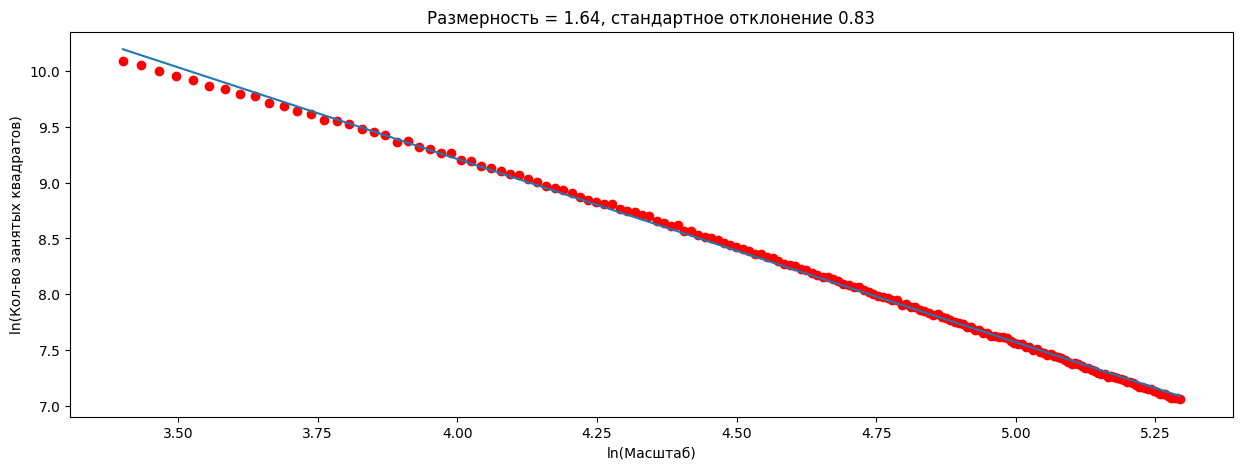

Начальный шаг 40
Конечный шаг 200
Шаг 1
(3850, 15500)


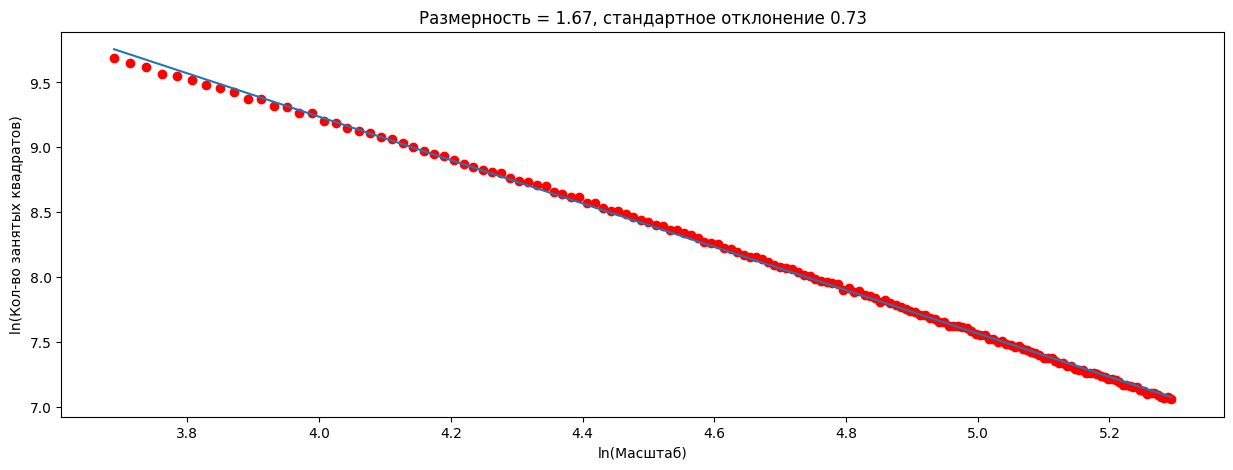

Начальный шаг 50
Конечный шаг 200
Шаг 1
(3850, 15500)


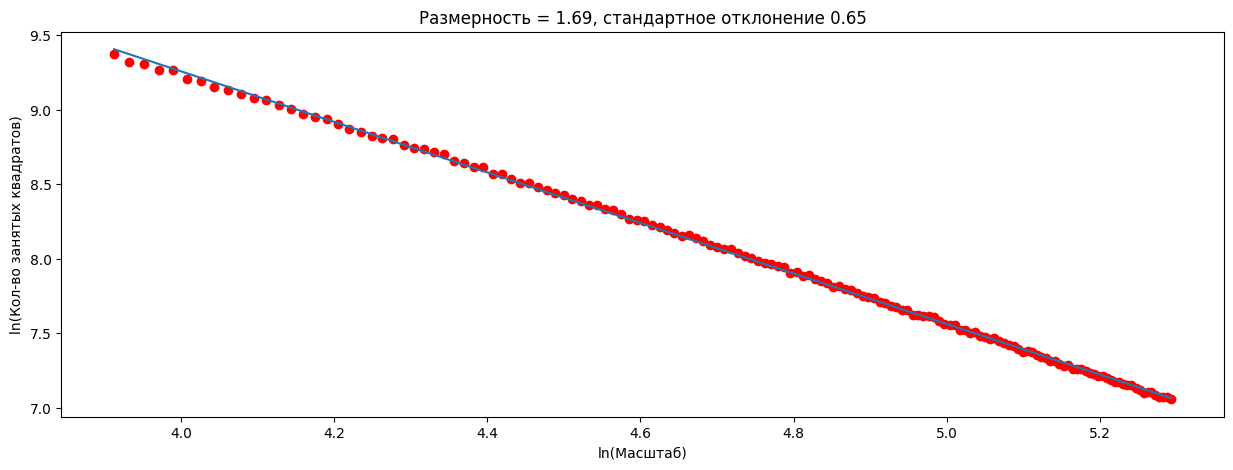

Начальный шаг 60
Конечный шаг 200
Шаг 1
(3850, 15500)


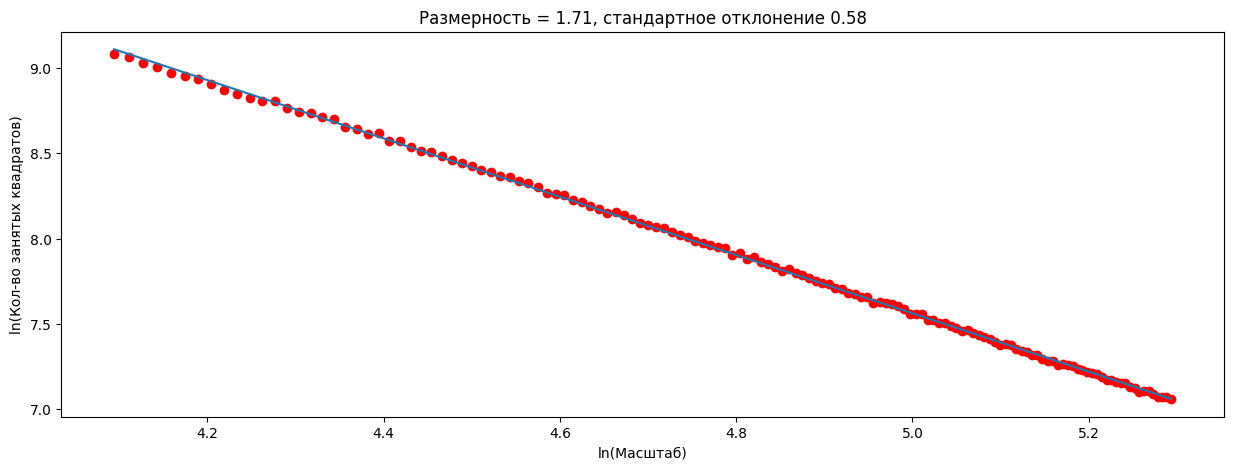

Начальный шаг 70
Конечный шаг 200
Шаг 1
(3850, 15500)


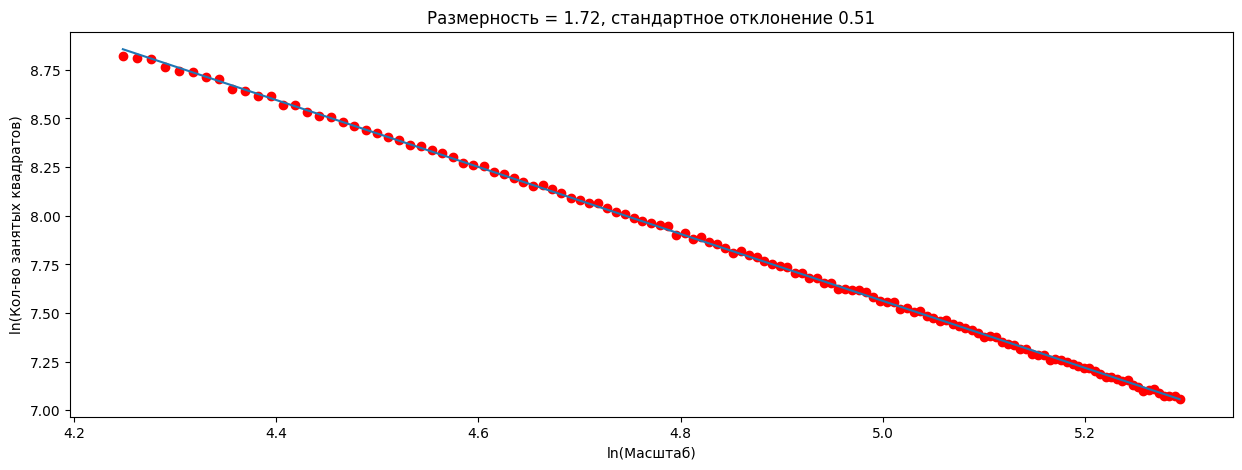

Начальный шаг 80
Конечный шаг 200
Шаг 1
(3850, 15500)


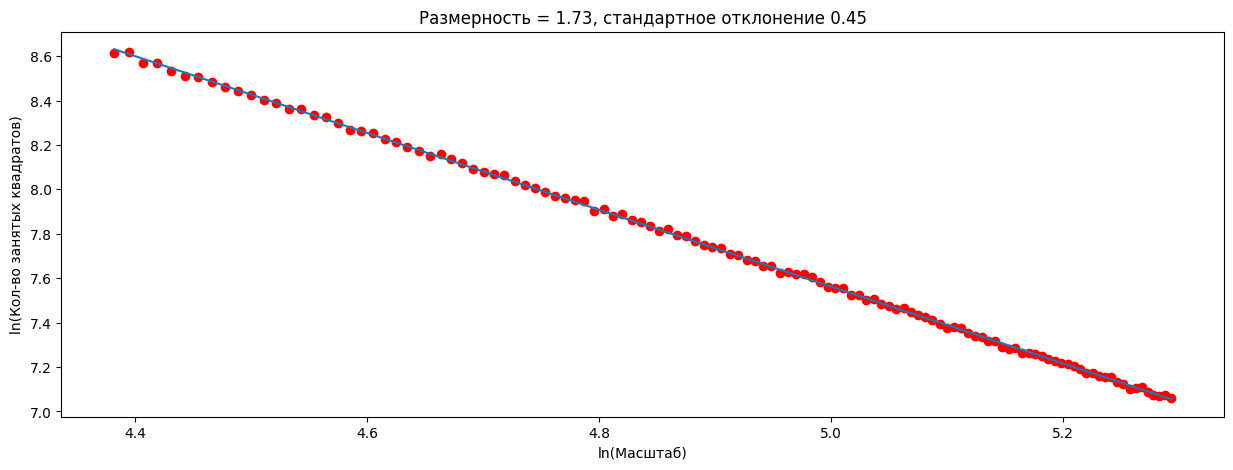

In [15]:
for start_step, end_step, step in zip([5, 10, 20, 30, 40, 50, 60, 70, 80], [200]*9, [1]*9):
    print(f'Начальный шаг {start_step}')
    print(f'Конечный шаг {end_step}')
    print(f'Шаг {step}')
    D = Dimension_BC(stochastic_df, ['index', 'R'], start_step, end_step, step, show=True, Dimension=False)

## Зависимость отклонения от конечного шага

Начальный шаг 5
Конечный шаг 200
Шаг 1
(3850, 15500)


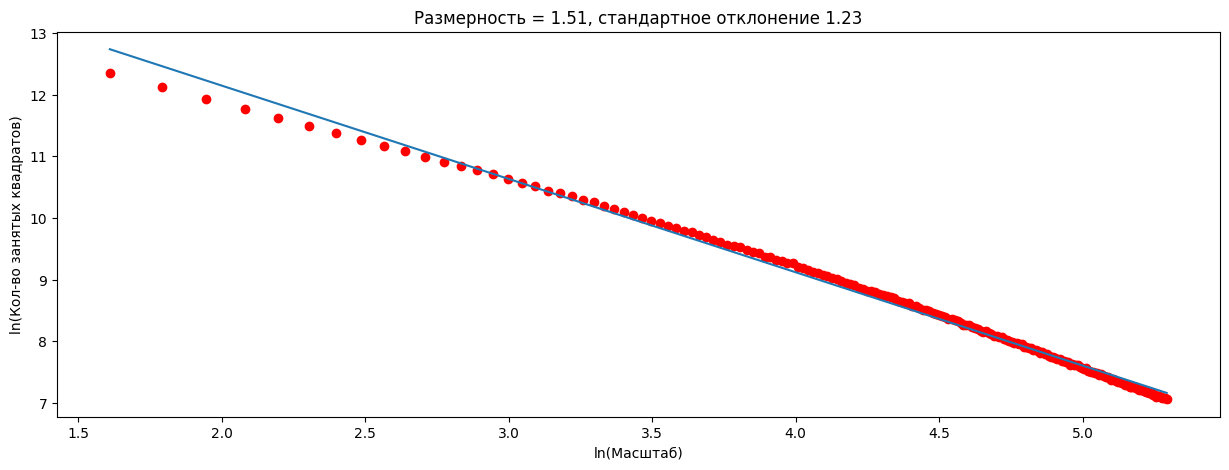

Начальный шаг 5
Конечный шаг 190
Шаг 1
(3850, 15500)


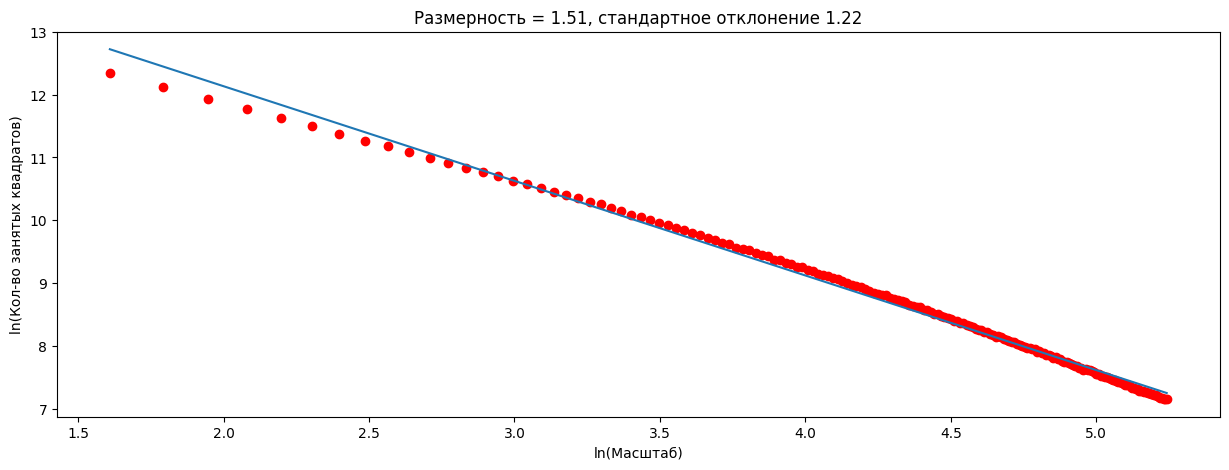

Начальный шаг 5
Конечный шаг 180
Шаг 1
(3850, 15500)


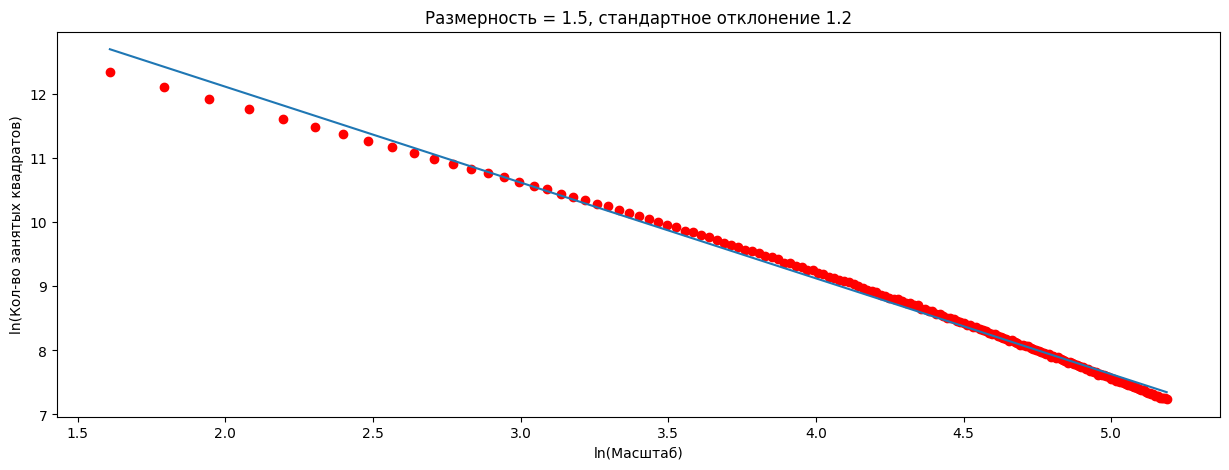

Начальный шаг 5
Конечный шаг 170
Шаг 1
(3850, 15500)


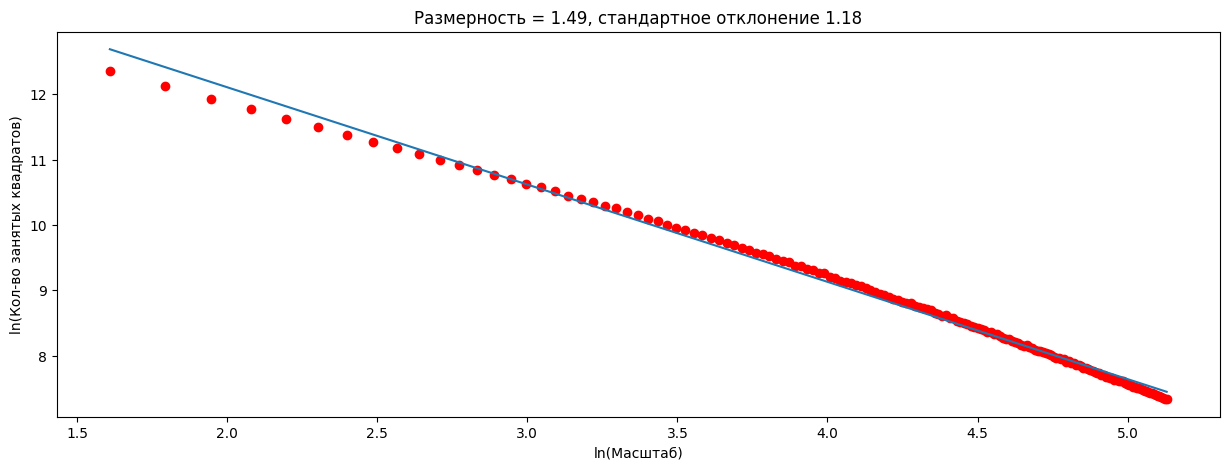

Начальный шаг 5
Конечный шаг 160
Шаг 1
(3850, 15500)


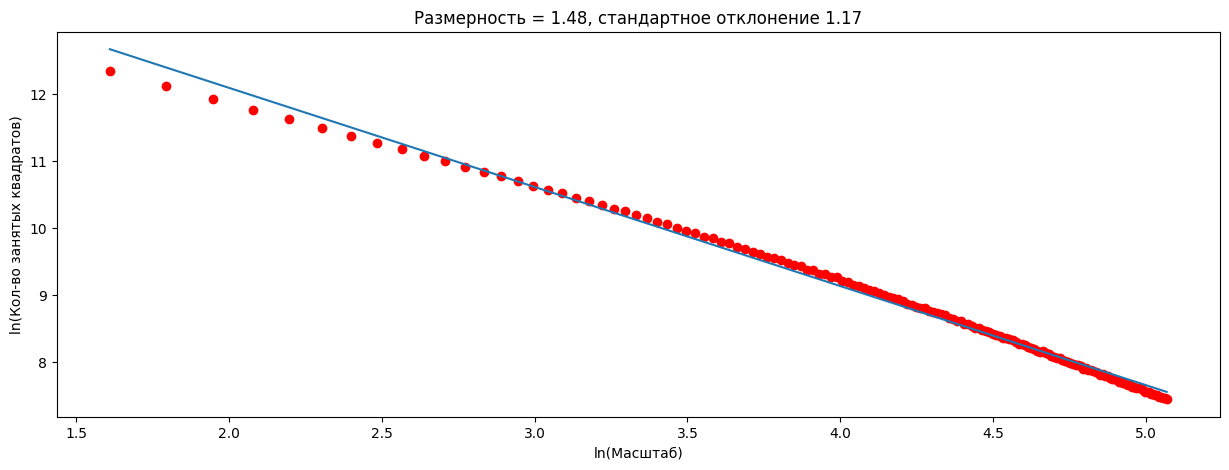

Начальный шаг 5
Конечный шаг 150
Шаг 1
(3850, 15500)


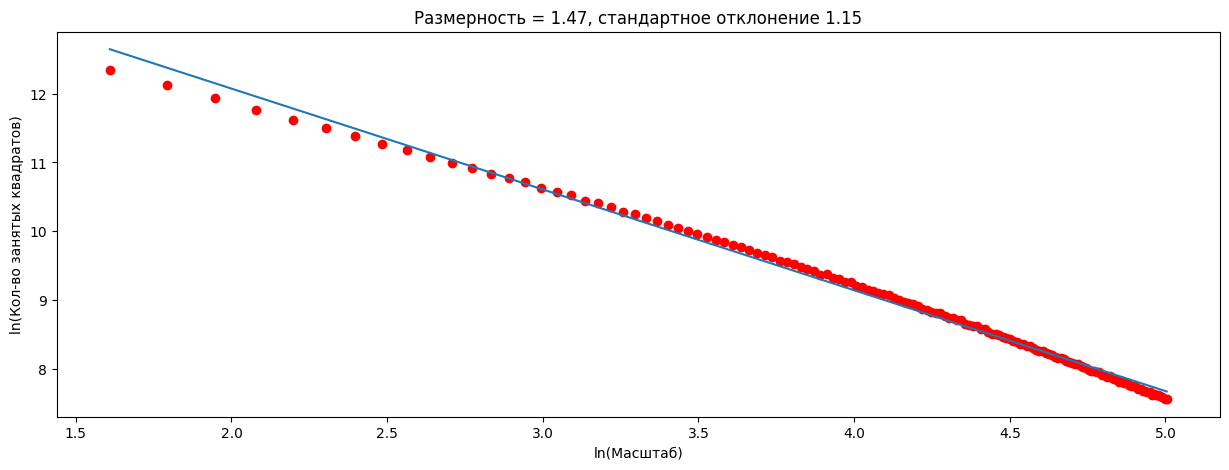

Начальный шаг 5
Конечный шаг 140
Шаг 1
(3850, 15500)


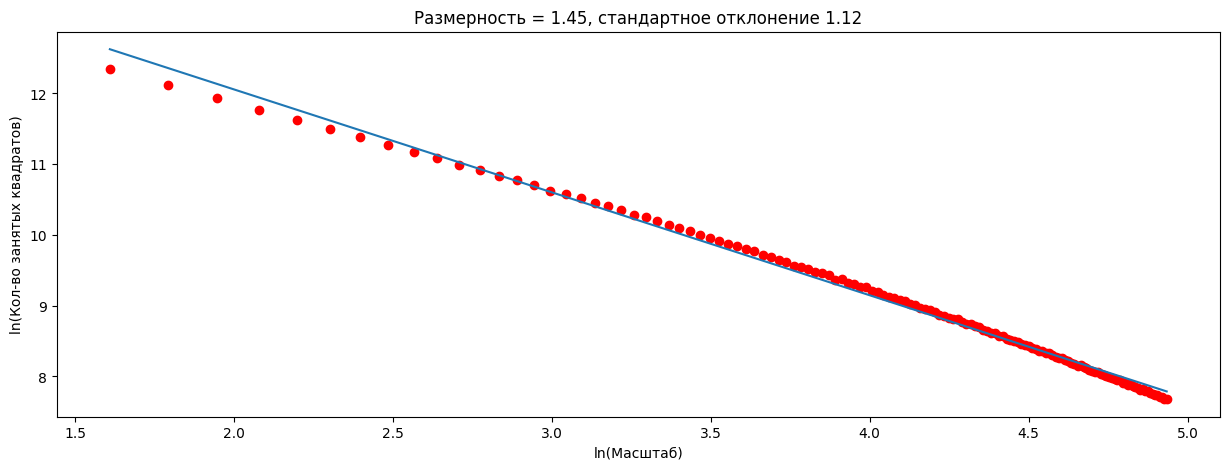

Начальный шаг 5
Конечный шаг 130
Шаг 1
(3850, 15500)


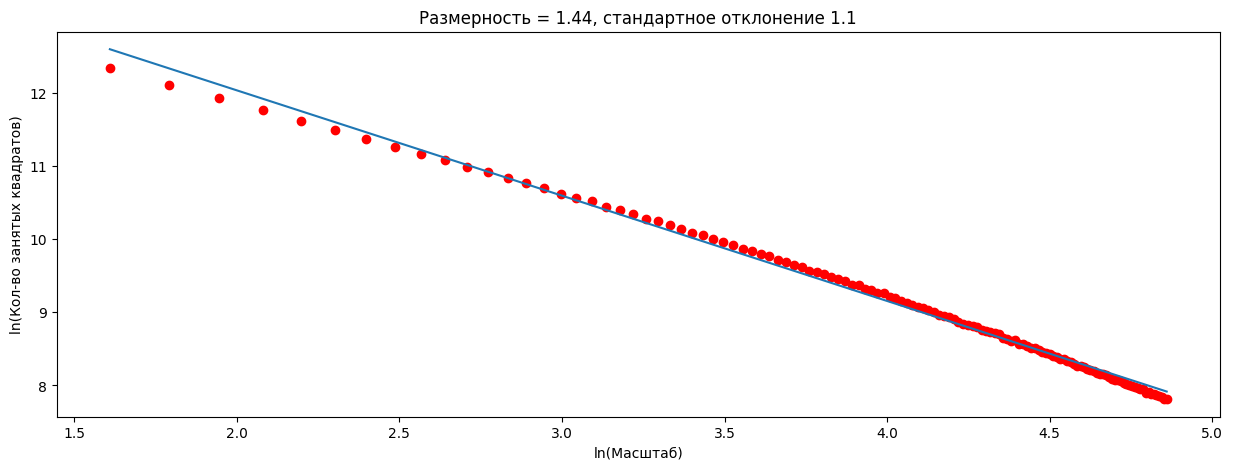

Начальный шаг 5
Конечный шаг 120
Шаг 1
(3850, 15500)


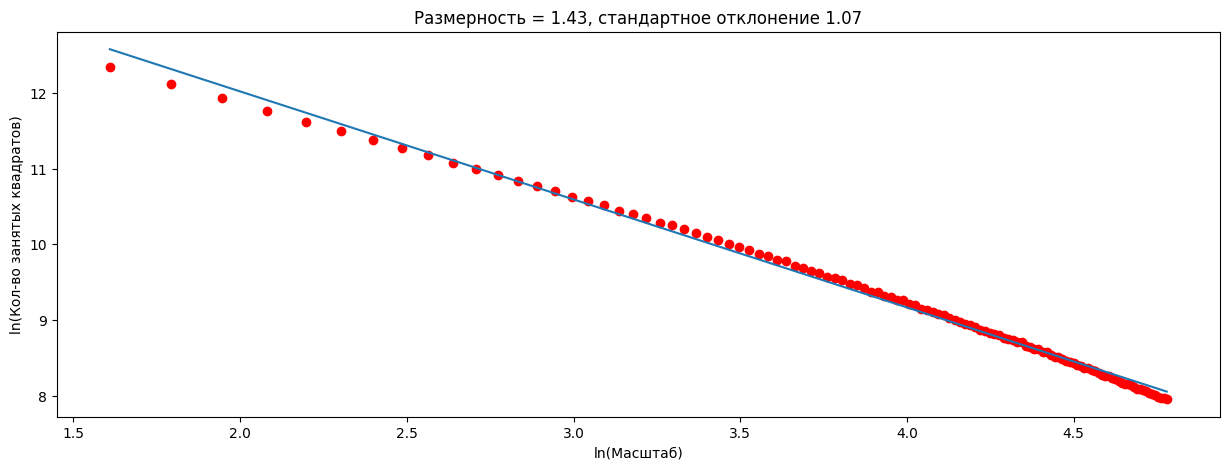

In [16]:
for start_step, end_step, step in zip([5]*9, [200, 190, 180, 170, 160, 150, 140, 130, 120]*9, [1]*9):
    print(f'Начальный шаг {start_step}')
    print(f'Конечный шаг {end_step}')
    print(f'Шаг {step}')
    D = Dimension_BC(stochastic_df, ['index', 'R'], start_step, end_step, step, show=True, Dimension=False)

## Идеальные параметры

(3850, 15500)


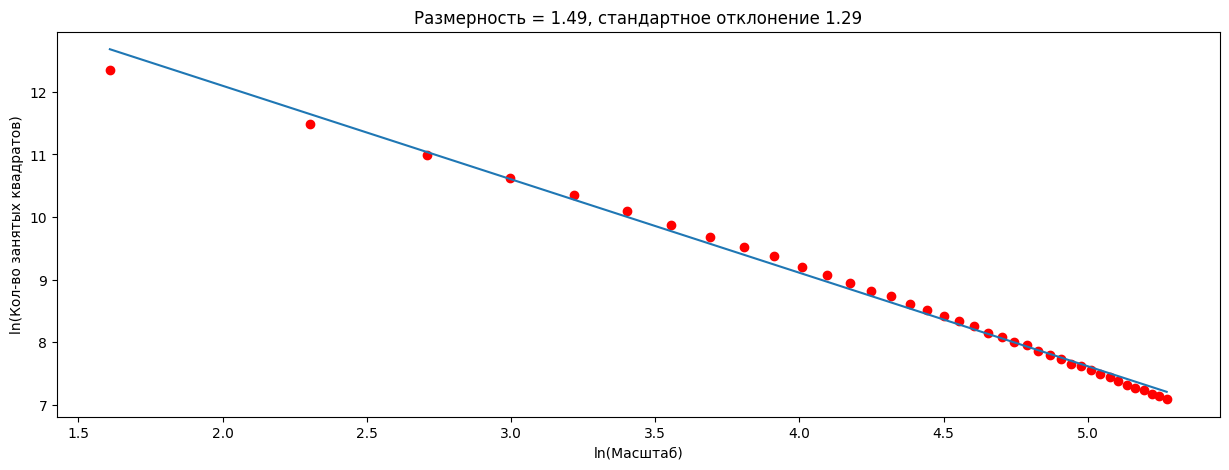

In [17]:
D = Dimension_BC(stochastic_df, ['index', 'R'], 5, 200, 5, show=True, Dimension=False)

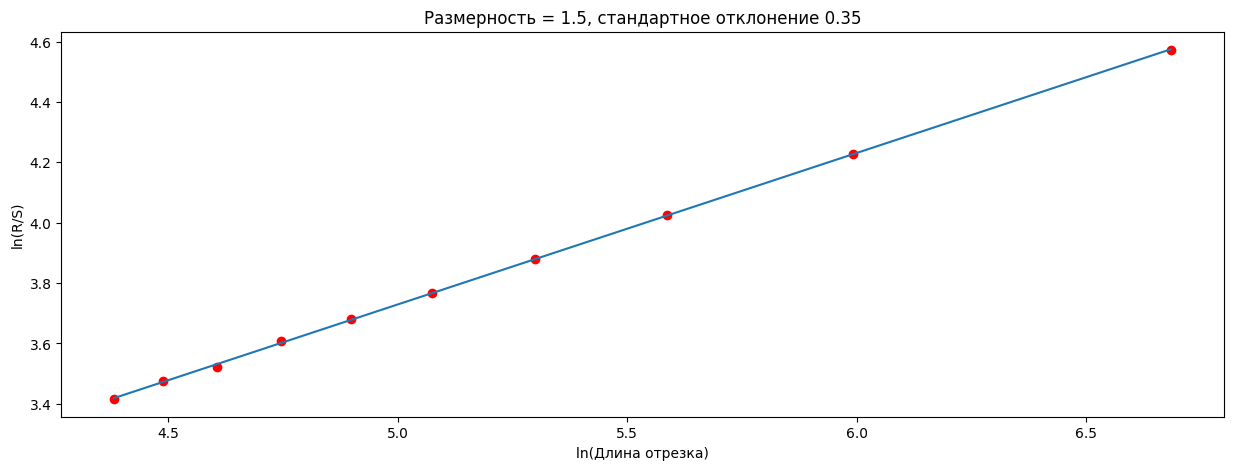

In [18]:
D_hurst = Dimension_Hurst(stochastic_df['R'], iter=10, show=True, Dimension=False)

## Сравнение адаптированного box counting и коэф-цт Хёрста

In [19]:
data = pd.read_csv('data/USD_RUB_investing.csv')

In [20]:
data = data.iloc[500:1400]
data['index'] = [i for i in range(len(data))]

In [21]:
data

,Дата,Закрытие,Открытие,Максимум,Минимум,Изм%,index
500,25.11.2021,74.6918,74.9821,74.9904,74.4950,-0.39,0
501,24.11.2021,74.9821,74.2883,75.0379,74.1181,0.93,1
502,23.11.2021,74.2883,74.8046,75.2510,74.1610,-0.69,2
503,22.11.2021,74.8046,73.4834,75.0528,73.2186,1.80,3
504,19.11.2021,73.4834,73.0995,73.6592,72.7025,0.53,4
...,...,...,...,...,...,...,...
1395,15.05.2018,62.3277,61.8468,62.7500,61.7968,0.78,895
1396,14.05.2018,61.8468,61.9193,61.9193,61.5616,-0.12,896
1397,11.05.2018,61.9193,61.7100,62.0341,61.4434,0.34,897
1398,10.05.2018,61.7100,63.2083,63.2250,61.5930,-2.37,898


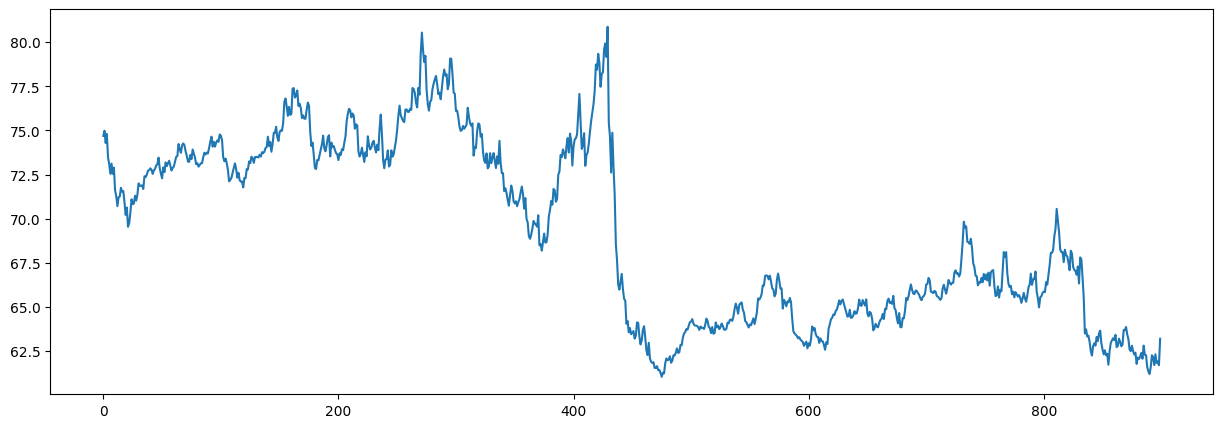

In [22]:
plt.figure(figsize=(15,5))
plt.plot(data['index'], data['Закрытие'])

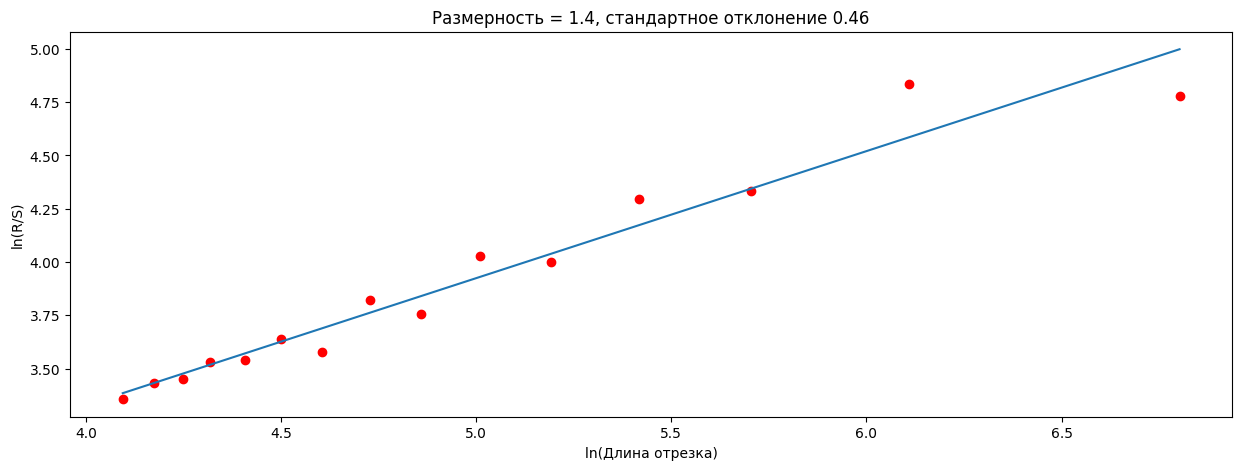

In [23]:
D_hurst = Dimension_Hurst(data['Максимум'], iter=15, show=True, Dimension=False)

(3850, 15500)


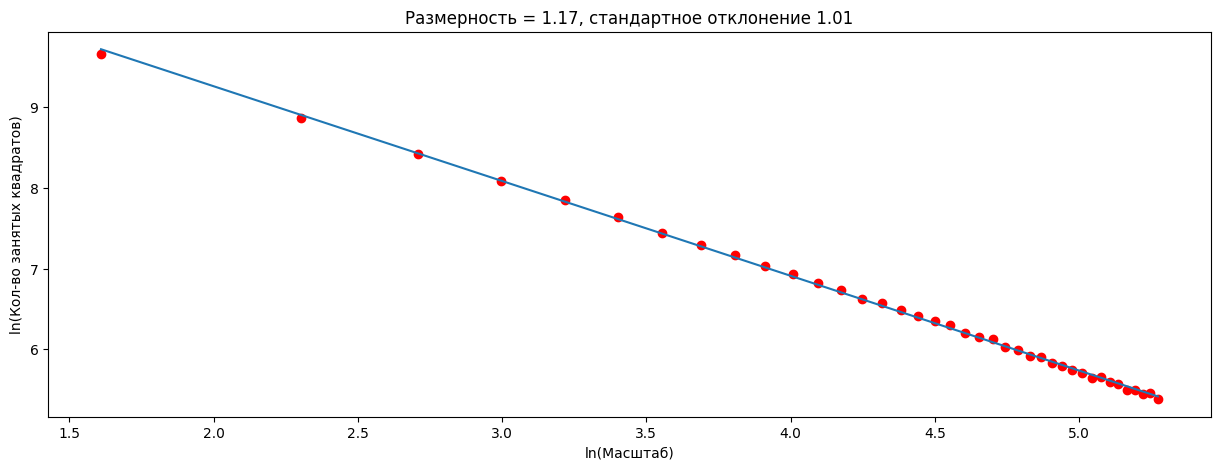

In [24]:
D = Dimension_BC(data, ['index', 'Максимум'], 5, 200, 5, show=True, Dimension=False)

## Оценка корреляции размерностей и Тренда, Размаха

In [25]:
analys = pd.read_excel('data/Результат_Закрытие_RUB.xlsx')
analys['Год'] = analys['Дата'].dt.year

In [26]:
analys = analys[['Закрытие', 'Объем', 'Изменение', 'Разм_Хёрст', 'Разм_BC', 'Тренд', 'Размах', 'Неделя', 'Год']]

In [27]:
analys = analys.groupby(by=['Год', 'Неделя'], as_index=False).agg({'Закрытие': 'mean',\
                                                                   'Объем' : 'max',\
                                                                   'Тренд': 'mean',\
                                                                   'Размах': 'mean',\
                                                                   'Разм_Хёрст': 'mean',\
                                                                   'Разм_BC': 'mean'})

In [28]:
analys

,Год,Неделя,Закрытие,Объем,Тренд,Размах,Разм_Хёрст,Разм_BC
0,2018,1,58.732475,116615,-0.000690,1.701913,1.462500,1.177500
1,2018,2,56.760929,200934,-0.000380,0.795200,1.590000,1.210000
2,2018,3,56.612429,239655,0.000152,0.638200,1.440000,1.220000
3,2018,4,56.214943,259471,-0.000533,1.100900,1.500000,1.200000
4,2018,5,56.294486,308785,-0.000037,0.687300,1.350000,1.250000
...,...,...,...,...,...,...,...,...
257,2022,48,60.848333,5018,0.003273,3.512000,1.440000,1.390000
258,2022,49,62.328667,16550,0.000198,2.222000,1.520000,1.290000
259,2022,50,63.522000,21718,0.003941,3.587000,1.580000,1.330000
260,2022,51,67.950000,1548,0.005392,8.322000,1.500000,1.330000


In [29]:
for year in analys['Год'].unique():
    window = analys.loc[analys['Год']==year]
    print(f'Год {year}')
    window = window.drop(columns=['Год'])
    display(window.corr().round(3)\
    .style\
    .background_gradient(cmap='Greens', vmin=0.3, vmax=1)\
    .set_properties(**{'color': 'black'})\
    .map(lambda v: 'opacity: 20%;' if (v < 0.3) and (v > -0.3) else None)\
    .map(lambda v: 'border: 3px solid orange;' if (v >= 0.6) or (v <= -0.6) else None)\
    .highlight_max(color='green')\
    .highlight_min(color='lightblue'))

Год 2018


,Неделя,Закрытие,Объем,Тренд,Размах,Разм_Хёрст,Разм_BC
Неделя,1.000000,0.921000,0.698000,0.081000,0.091000,-0.002000,0.089000
Закрытие,0.921000,1.000000,0.529000,0.100000,0.277000,0.072000,-0.130000
Объем,0.698000,0.529000,1.000000,0.172000,0.146000,-0.041000,0.054000
Тренд,0.081000,0.100000,0.172000,1.000000,0.346000,0.081000,-0.183000
Размах,0.091000,0.277000,0.146000,0.346000,1.000000,0.157000,-0.801000
Разм_Хёрст,-0.002000,0.072000,-0.041000,0.081000,0.157000,1.000000,-0.273000
Разм_BC,0.089000,-0.130000,0.054000,-0.183000,-0.801000,-0.273000,1.000000


Год 2019


,Неделя,Закрытие,Объем,Тренд,Размах,Разм_Хёрст,Разм_BC
Неделя,1.000000,-0.637000,0.098000,0.009000,-0.303000,-0.138000,0.217000
Закрытие,-0.637000,1.000000,-0.196000,-0.020000,0.391000,0.161000,-0.275000
Объем,0.098000,-0.196000,1.000000,-0.007000,0.200000,-0.057000,-0.061000
Тренд,0.009000,-0.020000,-0.007000,1.000000,-0.047000,-0.051000,0.073000
Размах,-0.303000,0.391000,0.200000,-0.047000,1.000000,0.085000,-0.786000
Разм_Хёрст,-0.138000,0.161000,-0.057000,-0.051000,0.085000,1.000000,-0.157000
Разм_BC,0.217000,-0.275000,-0.061000,0.073000,-0.786000,-0.157000,1.000000


Год 2020


,Неделя,Закрытие,Объем,Тренд,Размах,Разм_Хёрст,Разм_BC
Неделя,1.000000,0.684000,0.375000,-0.116000,-0.158000,0.081000,0.445000
Закрытие,0.684000,1.000000,0.445000,-0.072000,0.370000,0.220000,0.170000
Объем,0.375000,0.445000,1.000000,0.025000,0.004000,0.258000,0.192000
Тренд,-0.116000,-0.072000,0.025000,1.000000,0.356000,-0.043000,-0.258000
Размах,-0.158000,0.370000,0.004000,0.356000,1.000000,0.087000,-0.663000
Разм_Хёрст,0.081000,0.220000,0.258000,-0.043000,0.087000,1.000000,0.021000
Разм_BC,0.445000,0.170000,0.192000,-0.258000,-0.663000,0.021000,1.000000


Год 2021


,Неделя,Закрытие,Объем,Тренд,Размах,Разм_Хёрст,Разм_BC
Неделя,1.000000,-0.490000,0.038000,0.076000,-0.013000,-0.191000,-0.032000
Закрытие,-0.490000,1.000000,-0.272000,0.066000,0.323000,0.076000,-0.186000
Объем,0.038000,-0.272000,1.000000,-0.083000,-0.290000,0.165000,0.041000
Тренд,0.076000,0.066000,-0.083000,1.000000,0.273000,-0.155000,-0.211000
Размах,-0.013000,0.323000,-0.290000,0.273000,1.000000,0.061000,-0.847000
Разм_Хёрст,-0.191000,0.076000,0.165000,-0.155000,0.061000,1.000000,-0.089000
Разм_BC,-0.032000,-0.186000,0.041000,-0.211000,-0.847000,-0.089000,1.000000


Год 2022


,Неделя,Закрытие,Объем,Тренд,Размах,Разм_Хёрст,Разм_BC
Неделя,1.000000,-0.588000,-0.601000,0.257000,-0.370000,-0.080000,0.794000
Закрытие,-0.588000,1.000000,0.224000,-0.344000,0.796000,-0.097000,-0.488000
Объем,-0.601000,0.224000,1.000000,0.130000,-0.149000,-0.036000,-0.661000
Тренд,0.257000,-0.344000,0.130000,1.000000,-0.277000,-0.013000,-0.008000
Размах,-0.370000,0.796000,-0.149000,-0.277000,1.000000,-0.072000,-0.355000
Разм_Хёрст,-0.080000,-0.097000,-0.036000,-0.013000,-0.072000,1.000000,-0.169000
Разм_BC,0.794000,-0.488000,-0.661000,-0.008000,-0.355000,-0.169000,1.000000
